In [1]:
import numpy as np
import pickle
import os
from astropy.table import Table

from matplotlib import pyplot as plt

# Data Loading

In [2]:
pzchat = np.load('../outputs/p_z_chat/BFD_v1.npy')
pzchat_weights = np.load('../outputs/p_z_chat/BFD_v1_weights.npy')

avg = np.load('../outputs/p_z_chat/BFD_v1_avg.npy')
std = np.load('../outputs/p_z_chat/BFD_v1_std.npy')

redshifts = np.load('../outputs/p_z_chat/redshifts.npy')

with open('../outputs/mock_assignments/old/wide_positions.pkl', 'rb') as f:
    wp = pickle.load(f)
with open('../outputs/mock_assignments/old/redshifts.pkl', 'rb') as f:
    z = pickle.load(f)

In [3]:
ng = np.sum([len(w) for w in wp])
print(ng, "galaxies to process")

3001792 galaxies to process


## Initial Trash Bin Cut and Processing
First, we will remove wide cells with large standard deviations, putting them into a separate bin (the trash bin). 

In [4]:
trash_bins = np.where(std > 0.5)[0]

In [5]:
all_z = [] ; all_wc = []
rejected_z = [] ; rejected_wc = []
for zz, w in zip(z, wp):
    accepted_wc = [wc for wc in w if wc not in trash_bins]
    all_z = np.append(all_z, [zz]*len(accepted_wc))
    all_wc = np.append(all_wc, accepted_wc)
    
    rejected_wc = [wc for wc in w if wc in trash_bins]
    rejected_z = np.append(rejected_z, [zz]*len(rejected_wc))
    rejected_wc = np.append(rejected_wc, rejected_wc)

In [6]:
print("%.02f percent of galaxies in the trash bin"%((len(rejected_z)/len(all_z))*100))

5.56 percent of galaxies in the trash bin


In [7]:
t = Table([all_z, all_wc], names=['Z', 'WC'])
grouped_by_cell = t.group_by('WC')
averages = grouped_by_cell.groups.aggregate(np.nanmean)
averages.sort('Z')

# 4 Bins

In [8]:
nbins = 4
bins = [] ; current_total = 0
for z, cell in averages:
    group = t[t['WC']==cell]
    current_total += len(group)
    if current_total//(len(all_z)/nbins) > len(bins):
        bins += [z]
print(bins)

[0.4221123266322495, 0.6598177554479839, 0.8981140689960896, 1.8220950515132468]


In [9]:
print(bins)
dig_all_data = np.digitize(all_z, bins=bins)
[len(all_z[dig_all_data==i]) for i in range(nbins)]

[0.4221123266322495, 0.6598177554479839, 0.8981140689960896, 1.8220950515132468]


[776139, 605167, 755213, 684406]

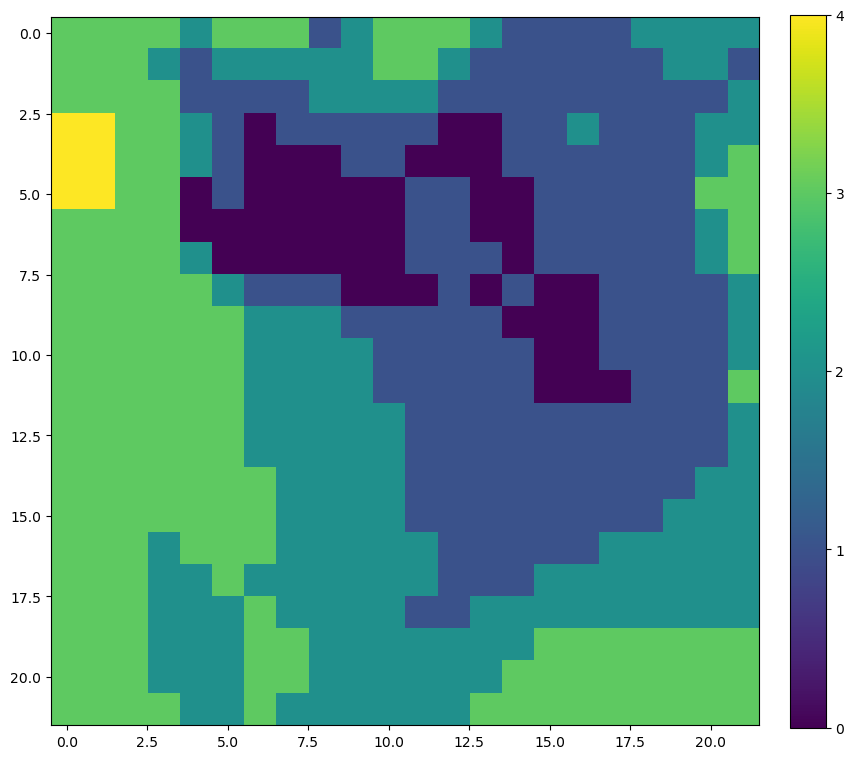

In [10]:
binned_data = np.array(np.digitize(avg, bins=bins), dtype=float)
plt.imshow(binned_data.reshape((22,22)))
plt.gcf().set_size_inches(10,10)
plt.colorbar(ticks=[0,1,2,3,4], fraction=0.046, pad=0.04)
plt.show()

In [11]:
fname = '../../SOM-photoz-BFD/outputs/binned_data/4_binned_all_data.pkl'
if not os.path.exists(fname):
    binned_all_data = []
    for bindex in range(nbins+1):
        wcs = np.where(binned_data==bindex)[0]
        binned_all_data += [np.array([c in wcs for c in all_wc])]
else:
    with open(fname, 'rb') as f:
        binned_all_data = pickle.load(f)

In [12]:
all_wc[binned_all_data[0]]

array([142., 164., 163., ..., 141., 163., 141.])

487801
951647
694246
709101


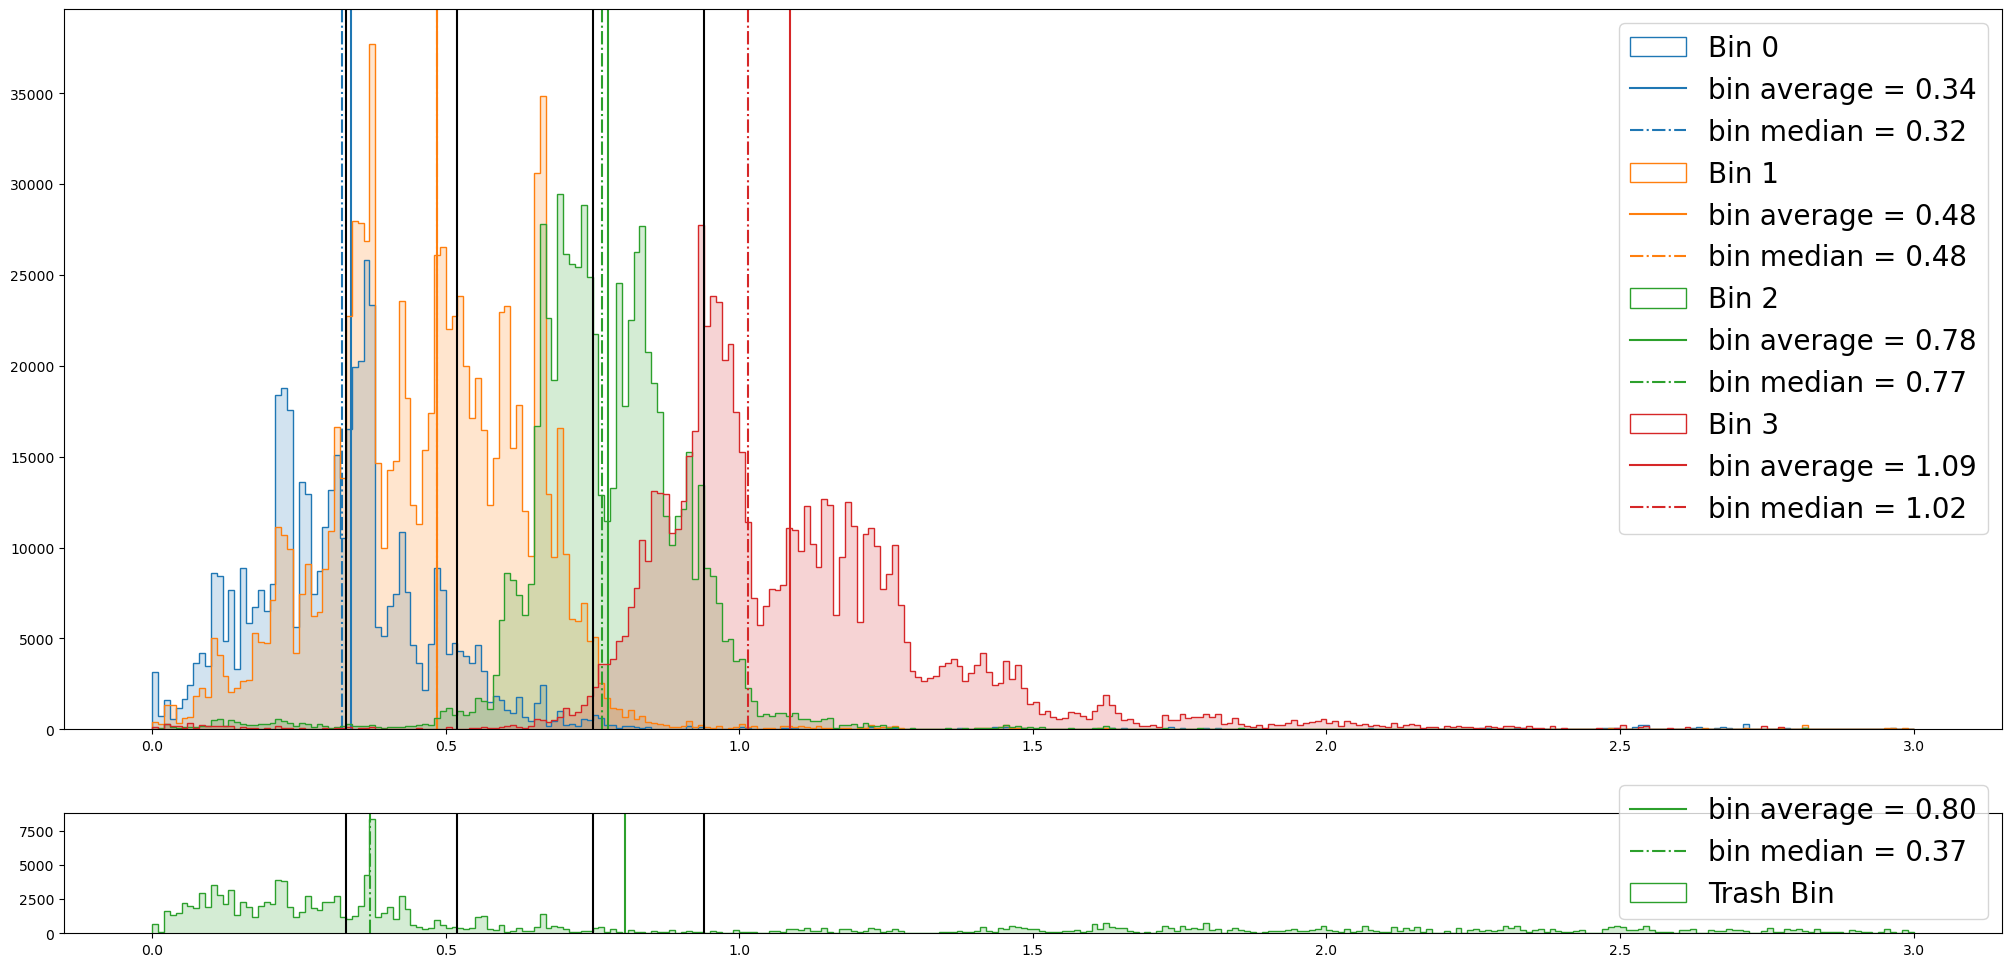

In [13]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,12), height_ratios=[6,1])
r = (0,3)
for i,mask in enumerate(binned_all_data[:-1]):
    print(len(all_z[mask]))
    ax[0].hist(all_z[mask], 300, range=r,histtype='step', color=colors[i], label="Bin %i"%i)
    ax[0].hist(all_z[mask], 300, range=r, alpha=0.2, color=colors[i])
    
    av = np.average(all_z[mask]) ; med = np.median(all_z[mask])
    ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    ax[0].axvline(med, linestyle='-.', color=colors[i], label='bin median = %.02f'%med)
    

av = np.average(rejected_z) ; med = np.median(rejected_z)
ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
ax[1].axvline(med, linestyle='-.', color=colors[2], label='bin median = %.02f'%med)
ax[1].hist(rejected_z, 300, range=r, alpha=0.2, color=colors[2])
ax[1].hist(rejected_z, 300, range=r, color=colors[2], histtype='step', label='Trash Bin')

y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')

ax[0].legend(fontsize=20)
ax[1].legend(fontsize=20)
plt.show()

In [14]:
# save bins
with open('../../SOM-photoz-BFD/outputs/binned_data/4_binned_all_data.pkl', 'wb') as f:
    pickle.dump(binned_all_data, f)

for i,mask in enumerate(binned_all_data):
    widemap = np.zeros(22*22, dtype=int)
    
    wc = all_wc[mask]
    wide_cells = np.array(list(set(wc)), dtype=int)
    widemap[wide_cells] = 1
    with open('../../SOM-photoz-BFD/outputs/SOM_masks/4_bin%i.pkl', 'wb') as f:
        pickle.dump(widemap, f)

# 5 Bins

In [15]:
nbins = 5
bins = [] ; current_total = 0
for z, cell in averages:
    group = t[t['WC']==cell]
    current_total += len(group)
    if current_total//(len(all_z)/nbins) > len(bins):
        bins += [z]
print(bins)

[0.4028831640591368, 0.5271493598550435, 0.7427143052172499, 0.9354421640898146]


In [16]:
print(bins)
dig_all_data = np.digitize(all_z, bins=bins)
[len(all_z[dig_all_data==i]) for i in range(nbins)]

[0.4028831640591368, 0.5271493598550435, 0.7427143052172499, 0.9354421640898146]


[725116, 318333, 669905, 537764, 592579]

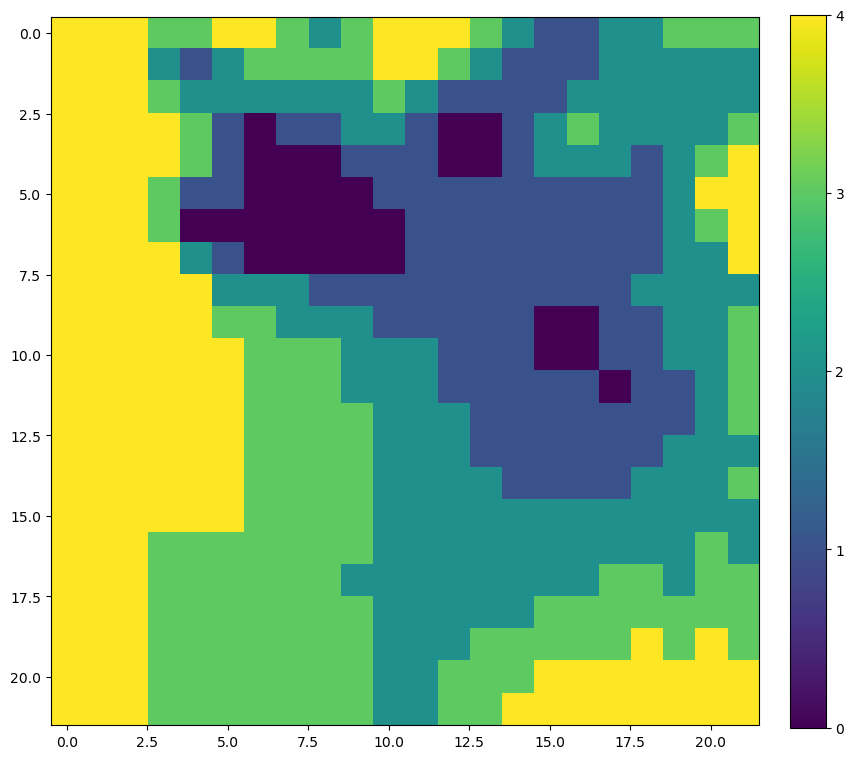

In [17]:
binned_data = np.array(np.digitize(avg, bins=bins), dtype=float)
plt.imshow(binned_data.reshape((22,22)))
plt.gcf().set_size_inches(10,10)
plt.colorbar(ticks=[0,1,2,3,4], fraction=0.046, pad=0.04)
plt.show()

In [18]:
fname = '../../SOM-photoz-BFD/outputs/binned_data/5_binned_all_data.pkl'
if True:#not os.path.exists(fname):
    binned_all_data = []
    for bindex in range(nbins+1):
        wcs = np.where(binned_data==bindex)[0]
        binned_all_data += [np.array([c in wcs for c in all_wc])]
else:
    with open(fname, 'rb') as f:
        binned_all_data = pickle.load(f)

In [19]:
all_wc[binned_all_data[0]]

array([142., 164., 163., ..., 141., 163., 141.])

308747
758808
609938
638671
527533


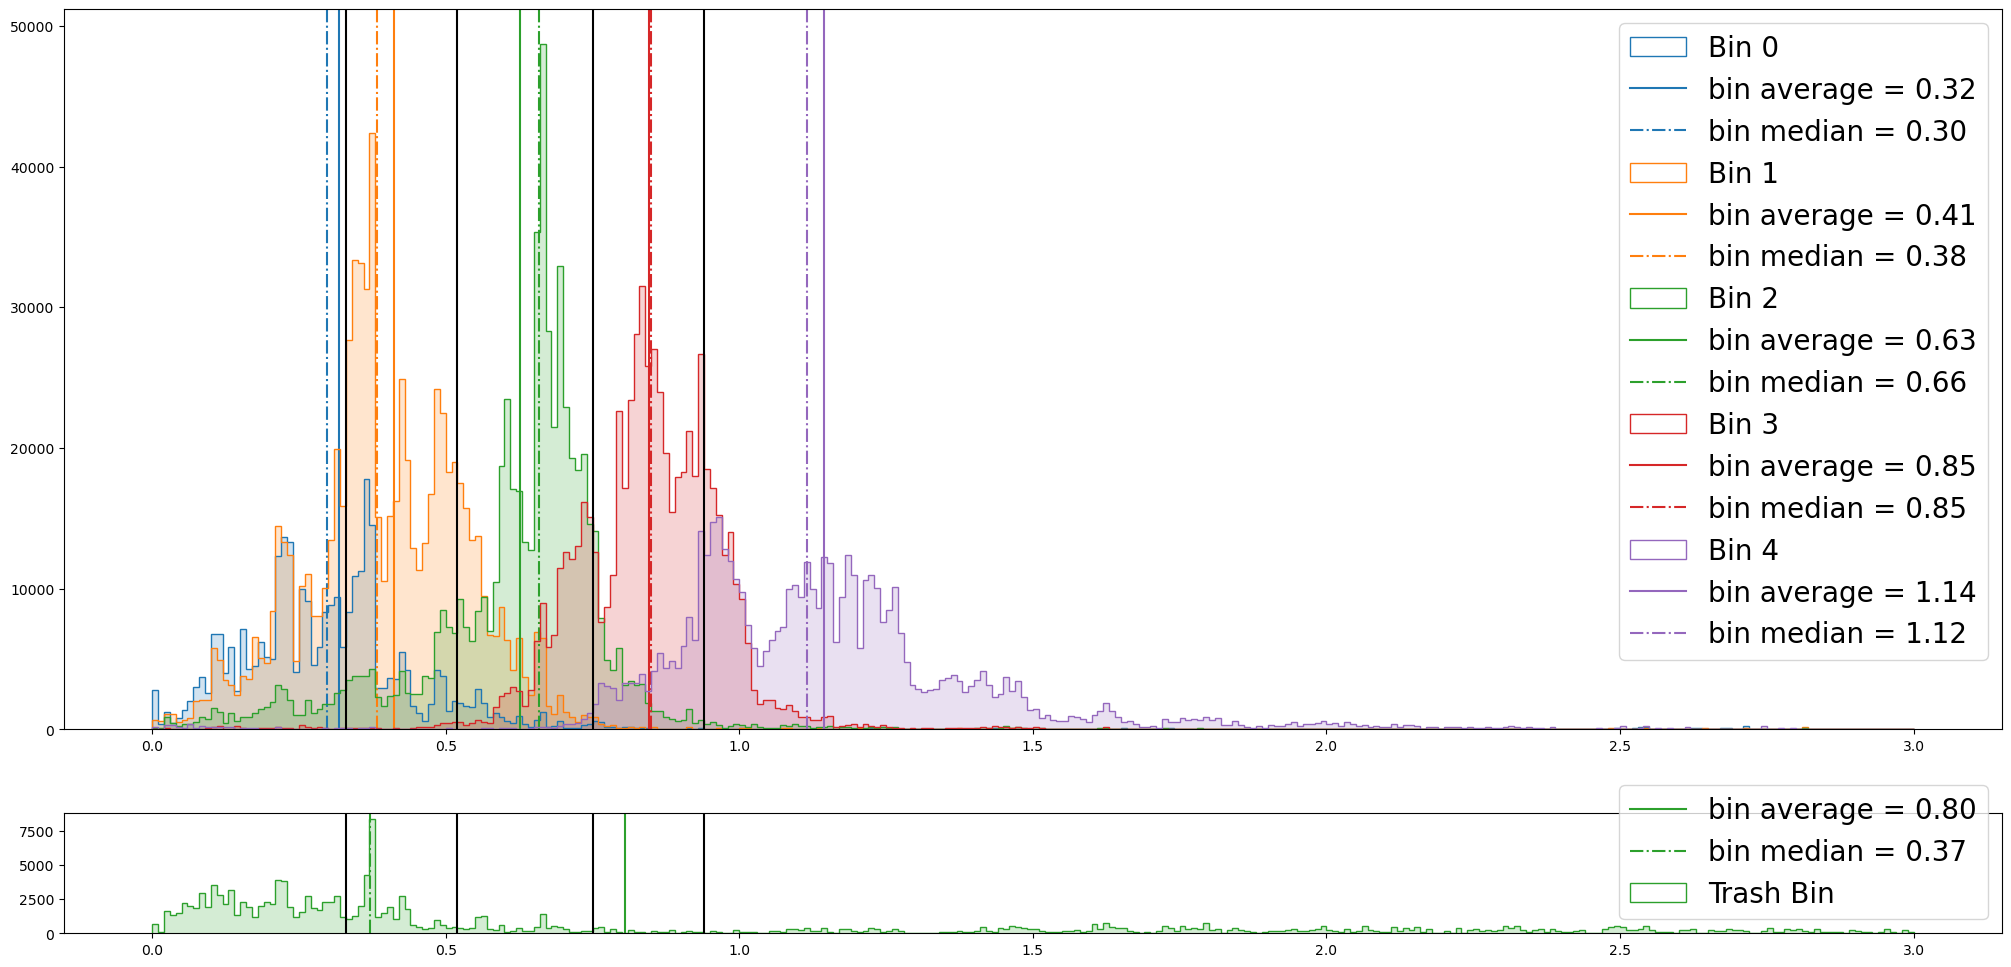

In [20]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,12), height_ratios=[6,1])
r = (0,3)
for i,mask in enumerate(binned_all_data[:-1]):
    print(len(all_z[mask]))
    ax[0].hist(all_z[mask], 300, range=r,histtype='step', color=colors[i], label="Bin %i"%i)
    ax[0].hist(all_z[mask], 300, range=r, alpha=0.2, color=colors[i])
    
    av = np.average(all_z[mask]) ; med = np.median(all_z[mask])
    ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    ax[0].axvline(med, linestyle='-.', color=colors[i], label='bin median = %.02f'%med)
    

av = np.average(rejected_z) ; med = np.median(rejected_z)
ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
ax[1].axvline(med, linestyle='-.', color=colors[2], label='bin median = %.02f'%med)
ax[1].hist(rejected_z, 300, range=r, alpha=0.2, color=colors[2])
ax[1].hist(rejected_z, 300, range=r, color=colors[2], histtype='step', label='Trash Bin')

y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')

ax[0].legend(fontsize=20)
ax[1].legend(fontsize=20)
plt.show()

In [21]:
# save bins
with open('../../SOM-photoz-BFD/outputs/binned_data/5_binned_all_data.pkl', 'wb') as f:
    pickle.dump(binned_all_data, f)

for i,mask in enumerate(binned_all_data):
    widemap = np.zeros(22*22, dtype=int)
    
    wc = all_wc[mask]
    wide_cells = np.array(list(set(wc)), dtype=int)
    widemap[wide_cells] = 1
    with open('../../SOM-photoz-BFD/outputs/SOM_masks/5_bin%i.pkl', 'wb') as f:
        pickle.dump(widemap, f)